In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from sklearn.preprocessing import LabelEncoder

In [10]:
# Baca dataset asli
df = pd.read_csv('..\Dataset\dataset_dummy.csv')

# Encode genre_seni dan user_id
genre_encoder = LabelEncoder()
user_encoder = LabelEncoder()

df['genre_encoded'] = genre_encoder.fit_transform(df['genre_seni'])
df['user_encoded'] = user_encoder.fit_transform(df['user_id'])

# Jumlah unik genre dan user
n_genres = df['genre_encoded'].nunique()
n_users = df['user_encoded'].nunique()

In [11]:
# Embedding size
embedding_size = 64

In [12]:
# Input layer
user_input = Input(shape=(1,), name='user_input')
genre_input = Input(shape=(1,), name='genre_input')

# Embedding layer
user_embedding = Embedding(input_dim=n_users, output_dim=embedding_size,
                           input_length=1, name='user_embedding')(user_input)
genre_embedding = Embedding(input_dim=n_genres, output_dim=embedding_size,
                            input_length=1, name='genre_embedding')(genre_input)

# Flatten embedding
user_vector = Flatten(name='user_vector')(user_embedding)
genre_vector = Flatten(name='genre_vector')(genre_embedding)

# Dot product of user and genre vectors
dot_product = Dot(axes=1, name='dot_product')([user_vector, genre_vector])

In [13]:
# Model
model = Model(inputs=[user_input, genre_input], outputs=dot_product)
# model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.compile(optimizer='adam', loss='mse', metrics=[
              tf.keras.metrics.MeanSquaredError()])

# Latih model
history = model.fit([df['user_encoded'], df['genre_encoded']],
                    df['rating'], epochs=500, verbose=1)

# Mendapatkan embedding dari model yang sudah dilatih
user_embeddings = model.get_layer('user_embedding').get_weights()[0]
genre_embeddings = model.get_layer('genre_embedding').get_weights()[0]

Epoch 1/500
18/18 [==============================] - 1s 2ms/step - loss: 39.2243 - mean_squared_error: 39.2243
Epoch 2/500
18/18 [==============================] - 0s 2ms/step - loss: 39.1544 - mean_squared_error: 39.1544
Epoch 3/500
18/18 [==============================] - 0s 2ms/step - loss: 39.0571 - mean_squared_error: 39.0571
Epoch 4/500
18/18 [==============================] - 0s 2ms/step - loss: 38.8838 - mean_squared_error: 38.8838
Epoch 5/500
18/18 [==============================] - 0s 2ms/step - loss: 38.5762 - mean_squared_error: 38.5762
Epoch 6/500
18/18 [==============================] - 0s 2ms/step - loss: 38.0663 - mean_squared_error: 38.0663
Epoch 7/500
18/18 [==============================] - 0s 2ms/step - loss: 37.2718 - mean_squared_error: 37.2718
Epoch 8/500
18/18 [==============================] - 0s 2ms/step - loss: 36.1427 - mean_squared_error: 36.1427
Epoch 9/500
18/18 [==============================] - 0s 2ms/step - loss: 34.6532 - mean_squared_error: 34.6532
E

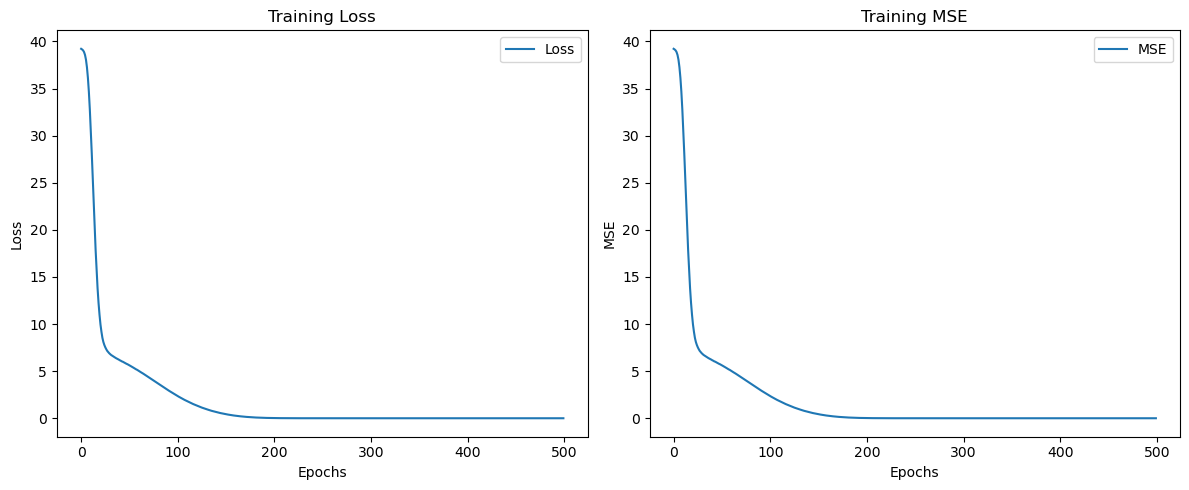

In [14]:
# Plot training loss and RMSE
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot RMSE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_squared_error'], label='MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training MSE')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Fungsi rekomendasi berdasarkan embedding
def recommend_art_based_on_genre_deep(user_id):
    # Mendapatkan embedding pengguna yang diberikan
    user_index = user_encoder.transform([user_id])[0]
    user_embedding = user_embeddings[user_index]

    # Menghitung skor untuk setiap genre
    scores = np.dot(genre_embeddings, user_embedding)

    # Mengurutkan genre berdasarkan skor tertinggi
    recommended_genre_indices = np.argsort(scores)[::-1]
    recommended_genres = genre_encoder.inverse_transform(
        recommended_genre_indices)

    return recommended_genres

In [16]:
# Fungsi untuk memberikan rekomendasi berdasarkan input pengguna baru tanpa menambah ke CSV
def recommend_art_for_new_user(new_user_ratings, num_recommendations=5):
    # Hitung embedding untuk user baru sebagai rata-rata embedding dari genre yang sudah dirating
    rated_genres = [rating[0] for rating in new_user_ratings]
    rated_ratings = [rating[1] for rating in new_user_ratings]

    rated_genre_indices = genre_encoder.transform(rated_genres)
    new_user_embedding = np.average(
        genre_embeddings[rated_genre_indices], axis=0, weights=rated_ratings)

    # Hitung kesamaan (similarity) antara embedding user baru dan semua embedding genre
    similarities = np.dot(genre_embeddings, new_user_embedding)

    # Mendapatkan genre seni dengan skor tertinggi
    recommended_indices = np.argsort(similarities)[-num_recommendations:][::-1]
    recommended_genres = genre_encoder.inverse_transform(recommended_indices)

    return recommended_genres

In [17]:
# Contoh penggunaan untuk user baru dengan id 102
new_user_ratings = [
    ('Impressionism', 10),
    ('Fauvism', 5),
    ('Pop', 8),
    ('Nouveau', 3)
]

recommended_genres = recommend_art_for_new_user(
    new_user_ratings, num_recommendations=5)
print(f"Rekomendasi genre seni untuk User 102: {recommended_genres}")

Rekomendasi genre seni untuk User 102: ['Pop' 'Impressionism' 'Nouveau' 'Fauvism' 'Realism']


In [19]:
# Save the model to a .h5 file
model.save('../Code/RecSys_CBF.h5')

In [20]:
import tensorflow as tf

# Load the Keras model
model = tf.keras.models.load_model('../Code/RecSys_CBF.h5')

# Convert the model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('..\Code\RecSys_CBF.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted successfully!")

INFO:tensorflow:Assets written to: C:\Users\DARMAW~1\AppData\Local\Temp\tmpoabg_06n\assets
Model converted successfully!
